In [1]:
import cv2
import numpy as np
import scipy
import imageio
import glob, os
from skimage.registration import phase_cross_correlation
from plot_utils import *
from tqdm import tqdm

image_paths = glob.glob('retina2/*.bmp')
input_images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in image_paths]

In [2]:
def generate_gif(images, filename, shift=False):

    with imageio.get_writer(filename, mode='I', fps=30) as writer:
        
        if shift:
            first_image = images[0]
            for image in tqdm(images, desc='Applying shifts'):
                shift, error, diffphase = phase_cross_correlation(first_image, image, upsample_factor=100,
                                                                  overlap_ratio=0.9, normalization=None)
                writer.append_data(scipy.ndimage.shift(image, shift))
        else:
            for image in images:
                writer.append_data(image)

### Temporal Averaging

In [3]:
tavgN, label_offset = 20, 172
UNLOCK_LOOP = False  # Set to True to run the loop

output_dir = f'viz_outputs/tavg_{tavgN}'
os.makedirs(output_dir, exist_ok=True)
shifts = []

'''
1) For each image, we calculate the phase cross correlation with the previous tavgN images.
2) We then shift the previous tavgN images by the calculated shifts.
   The shift is calculate w.r.t. the last image to simulate averaging the image history.
3) We then average the shifted images to get the temporal average.
4) We then calculate the maximum and minimum shifts in the x and y directions.
5) We then save the temporal average image and the shifts.

Note: The shifts are saved as (shift_lr_pos, shift_lr_neg, shift_ud_pos, shift_ud_neg) which are used for masking later.
'''

assert UNLOCK_LOOP, 'Set UNLOCK_LOOP to True to run the loop'


for i in tqdm(range(tavgN-1, len(input_images)), desc='Temporal averaging'):

    last_image = input_images[i]
    corrected_images = []

    shift_lr_pos, shift_lr_neg = 0, 0
    shift_ud_pos, shift_ud_neg = 0, 0

    for j in range(tavgN):

        offset_image = input_images[i-j]
        shift, error, diffphase = phase_cross_correlation(last_image, offset_image, upsample_factor=100,
                                                          overlap_ratio=0.9, normalization=None)
        corrected_image = scipy.ndimage.shift(offset_image, shift)
        corrected_images.append(corrected_image)

        if shift[1] > 0:
            shift_lr_pos = max(shift_lr_pos, shift[1])
        else:
            shift_lr_neg =  min(shift_lr_neg, shift[1])

        if shift[0] > 0:
            shift_ud_pos = max(shift_ud_pos, shift[0])
        else:
            shift_ud_neg = min(shift_ud_neg, shift[0])
    
    temporal = np.mean(corrected_images, axis=0).astype(np.uint8)
    cv2.imwrite(f'{output_dir}/{i-tavgN+label_offset+1}-{i+label_offset}.bmp', temporal)

    shift_lr_pos = int(shift_lr_pos) + 1
    shift_lr_neg = int(shift_lr_neg) - 1
    shift_ud_pos = int(shift_ud_pos) + 1
    shift_ud_neg = int(shift_ud_neg) - 1

    shift_lr_pos = shift_lr_pos if shift_lr_pos > 0 else 0
    shift_lr_neg = shift_lr_neg if shift_lr_neg < 0 else -1
    shift_ud_pos = shift_ud_pos if shift_ud_pos > 0 else 0
    shift_ud_neg = shift_ud_neg if shift_ud_neg < 0 else -1

    shifts.append((shift_lr_pos, shift_lr_neg, shift_ud_pos, shift_ud_neg))

shifts = np.array(shifts)
np.save(f'{output_dir}/shifts.npy', shifts)

AssertionError: Set UNLOCK_LOOP to True to run the loop

### Wiener Deconvolution

Use MATLAB scripts to generate results `final_all_matlab.m`

In [4]:
tavg_image_paths = glob.glob('viz_outputs/tavg_20/*.bmp')
tavg_input_images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in tavg_image_paths]

matlab_image_paths = glob.glob('viz_outputs/tavg_20_matlab_edges/*.mat')
matlab_input_images = [scipy.io.loadmat(image_path)['img'] for image_path in matlab_image_paths]
matlab_edge_images = [scipy.io.loadmat(image_path)['canny_nml']*255 for image_path in matlab_image_paths]

w_avg_input_images = [scipy.io.loadmat(image_path)['wnr_avg'] for image_path in matlab_image_paths]
w_avg_edge_images = [scipy.io.loadmat(image_path)['canny_avg']*255 for image_path in matlab_image_paths]

w_dsk_input_images = [scipy.io.loadmat(image_path)['wnr_dsk'] for image_path in matlab_image_paths]
w_dsk_edge_images = [scipy.io.loadmat(image_path)['canny_dsk']*255 for image_path in matlab_image_paths]

shifts = np.load('viz_outputs/tavg_20/shifts.npy')

### Edge Refinement Pipeline

In [5]:
# Remove edges which are too short
def remove_short_edges(edge_image, min_length=10):
    edge_image = edge_image.copy()
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        if len(contour) < min_length:
            cv2.drawContours(edge_image, [contour], 0, 0, -1)
    return edge_image

verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))

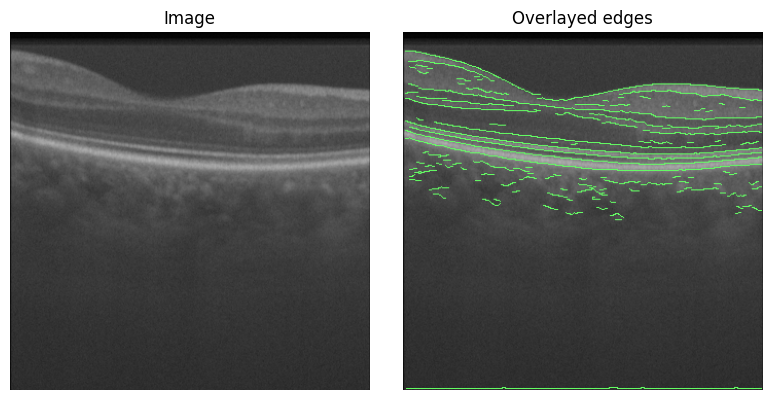

In [6]:
def fuse_edges(i, CL=0.1, CH=0.15):

    temporal_c1 = cv2.GaussianBlur(tavg_input_images[i], (0, 0), 1.5)
    temporal_c1 = cv2.Canny(temporal_c1, CL*temporal_c1.max(), CH*temporal_c1.max(), 3)
    temporal_c2 = cv2.GaussianBlur(w_avg_input_images[i], (0, 0), 1.5)
    temporal_c2 = cv2.Canny(temporal_c2, CL*temporal_c2.max(), CH*temporal_c2.max(), 3)
    temporal_c3 = cv2.GaussianBlur(w_dsk_input_images[i], (0, 0), 1.5)
    temporal_c3 = cv2.Canny(temporal_c3, CL*temporal_c3.max(), CH*temporal_c3.max(), 3)

    edges = [temporal_c1, temporal_c2, temporal_c3, matlab_edge_images[i], w_avg_edge_images[i], w_dsk_edge_images[i]]
    edge = np.clip(np.sum(np.array(edges), axis=0), 0, 255).astype(np.uint8)

    (shift_lr_pos, shift_lr_neg, shift_ud_pos, shift_ud_neg) = shifts[i]
    edge[:shift_ud_pos, :] = 0
    edge[shift_ud_neg:, :] = 0
    edge[:, :shift_lr_pos] = 0
    edge[:, shift_lr_neg:] = 0

    edge = cv2.ximgproc.thinning(edge, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
    edge = cv2.erode(edge, verticalStructure, iterations=1)
    edge = cv2.dilate(edge, verticalStructure, iterations=1)
    edge = cv2.dilate(edge[:, ::-1], verticalStructure, iterations=1)[:, ::-1]
    edge = cv2.ximgproc.thinning(edge, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
    edge = remove_short_edges(edge, min_length=10)

    return tavg_input_images[i], edge


img, edge = fuse_edges(0)
plot_overlay_edges([[None, edge]], [['Image', 'Overlayed edges']], img, dpi=100)

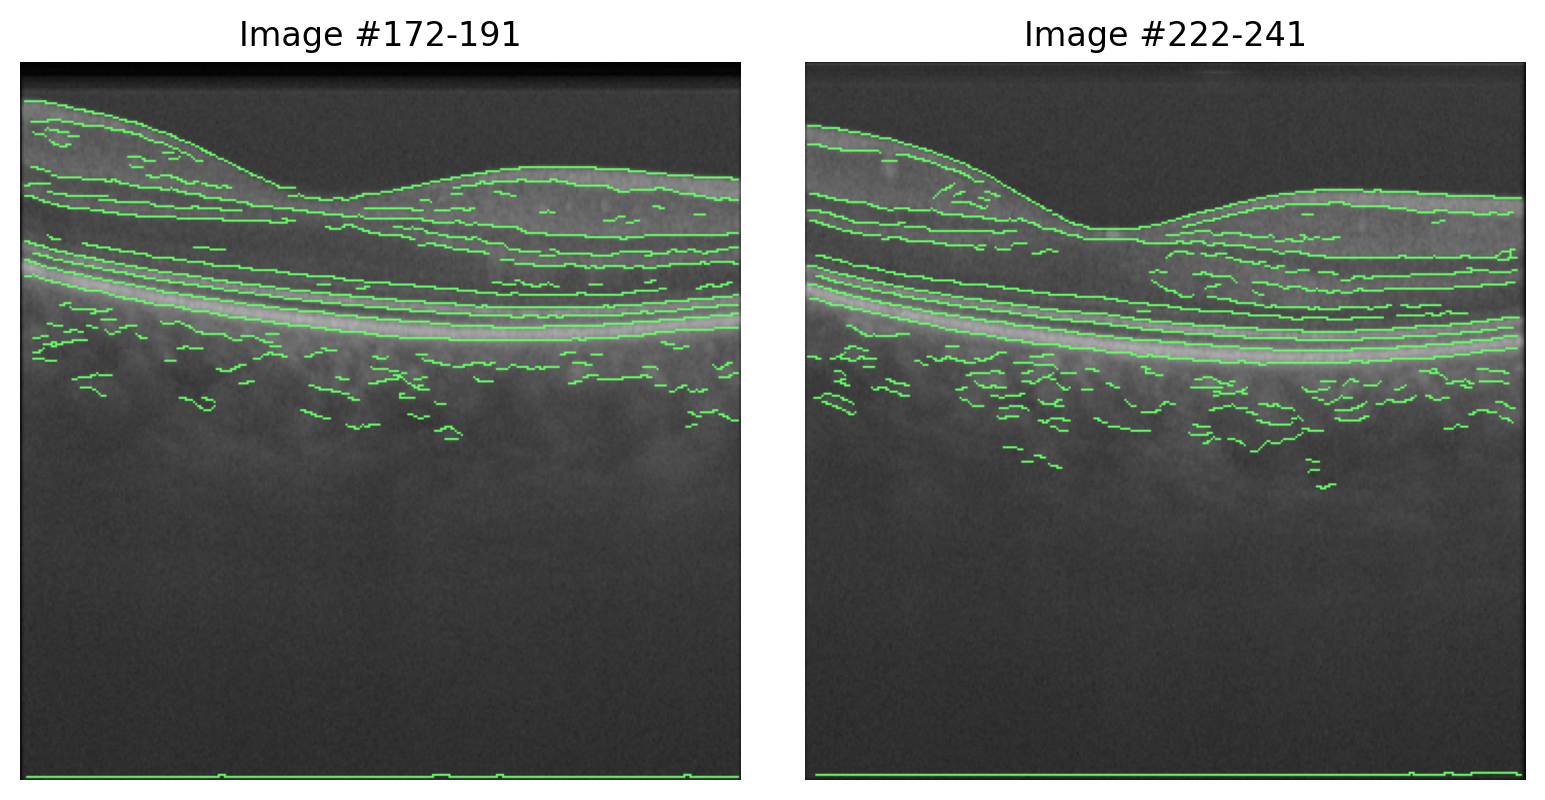

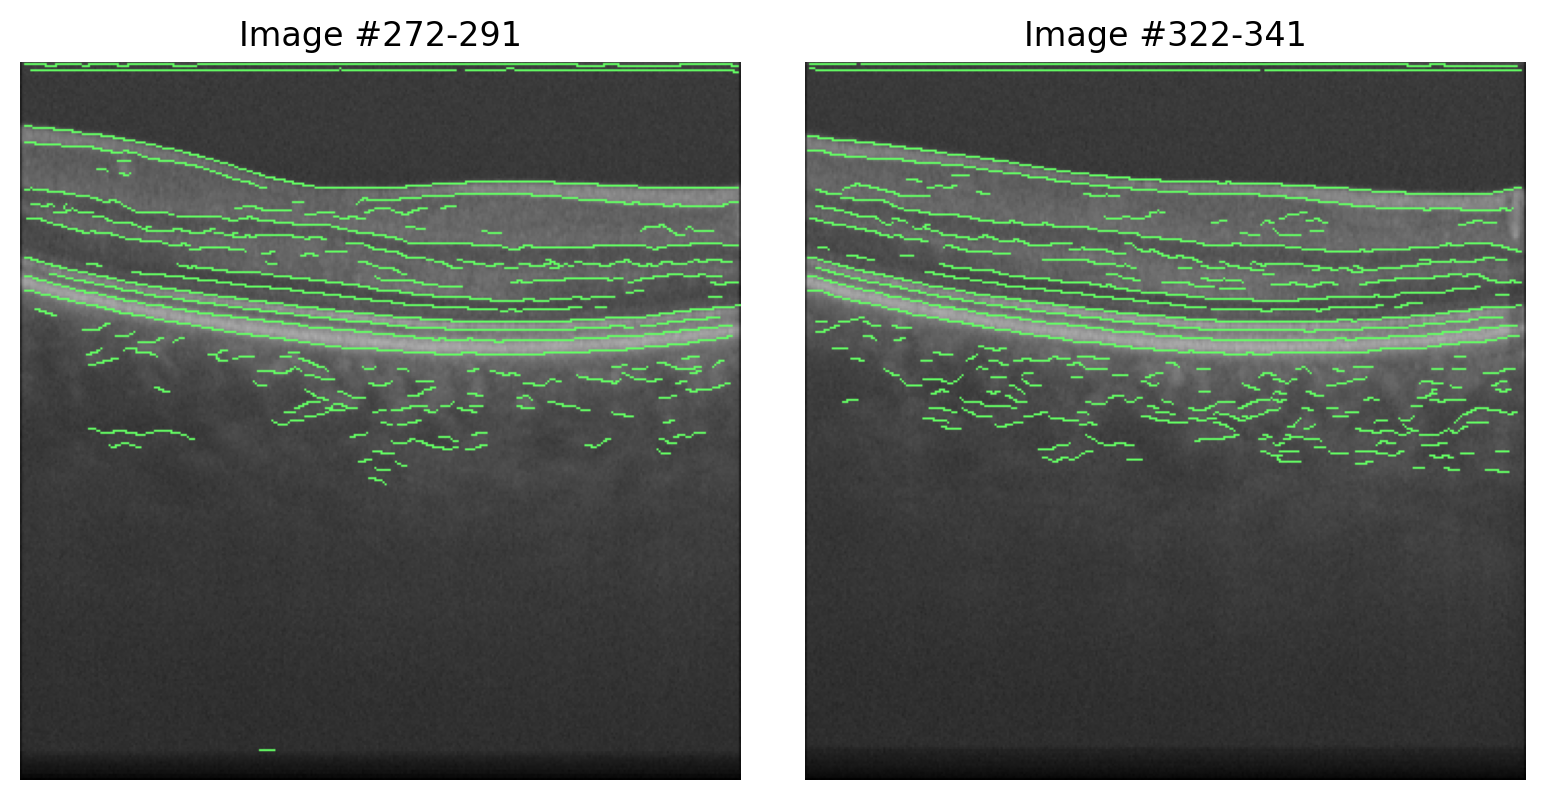

In [7]:
res = {'edge': [], 'image': [], 'title': []}

for i in range(0, 200, 50):
    img, edge = fuse_edges(i)
    res['edge'].append(edge)
    res['image'].append(img)
    res['title'].append(f'Image #{172+i}-{172+i+19}')

plot_overlay_edges_sep([res['edge'][:2]], [res['title'][:2]], [res['image'][:2]], dpi=200)
plot_overlay_edges_sep([res['edge'][2:]], [res['title'][2:]], [res['image'][2:]], dpi=200)

In [8]:
tavgN, label_offset = 20, 172
UNLOCK_LOOP = False  # Set to True to run the loop

output_dir1 = f'viz_outputs/tavg_{tavgN}_final_edges_only'
output_dir2 = f'viz_outputs/tavg_{tavgN}_final_edges_overlayed'
os.makedirs(output_dir1, exist_ok=True)
os.makedirs(output_dir2, exist_ok=True)

assert UNLOCK_LOOP, 'Set UNLOCK_LOOP to True to run the loop'


for i in tqdm(range(len(input_images)-tavgN+1), desc='Edge refinement'):

    img, edge = fuse_edges(i)

    overlay = np.repeat(np.expand_dims(img, -1), 3, axis=-1).astype(np.uint8)
    overlay[np.where(edge == 255)] = (100, 255, 100)
    
    cv2.imwrite(f'{output_dir1}/{i+label_offset}-{i+label_offset+tavgN-1}.bmp', edge)
    cv2.imwrite(f'{output_dir2}/{i+label_offset}-{i+label_offset+tavgN-1}.bmp', overlay)

AssertionError: Set UNLOCK_LOOP to True to run the loop

In [9]:
edges_image_paths = glob.glob('viz_outputs/tavg_20_final_edges_only/*.bmp')
edges_input_images = [cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in edges_image_paths]

final_image_paths = glob.glob('viz_outputs/tavg_20_final_edges_overlayed/*.bmp')
final_input_images = [cv2.imread(image_path) for image_path in final_image_paths]

### Generate GIF of images

<img src="viz_outputs/retina2_original.gif" alt="original"/><br>

<img src="viz_outputs/retina2_tvg_20_shifted.gif" alt="temporal averaging"/>
<img src="viz_outputs/retina2_wavg_20_shifted.gif" alt="wiener deconvolution: average"/>
<img src="viz_outputs/retina2_wdsk_20_shifted.gif" alt="wiener deconvolution: disk"/><br>

<img src="viz_outputs/retina2_final_edge_only_20_shifted.gif" alt="final edge only"/>
<img src="viz_outputs/retina2_final_edge_overlayed_20_shifted.gif" alt="final edge overlayed"/>

In [ ]:
## Uncomment this block to generate a GIF of the images

# generate_gif(input_images, 'viz_outputs/retina2_original.gif')
# generate_gif(tavg_input_images, 'viz_outputs/retina2_tvg_20.gif')
# generate_gif(tavg_input_images, 'viz_outputs/retina2_tvg_20_shifted.gif', shift=True)

# generate_gif(w_avg_input_images, 'viz_outputs/retina2_wavg_20.gif')
# generate_gif(w_avg_input_images, 'viz_outputs/retina2_wavg_20_shifted.gif', shift=True)
# generate_gif(w_dsk_input_images, 'viz_outputs/retina2_wdsk_20.gif')
# generate_gif(w_dsk_input_images, 'viz_outputs/retina2_wdsk_20_shifted.gif', shift=True)

In [ ]:
# ## Uncomment this block to generate a GIF of the images

# generate_gif(edges_input_images, 'viz_outputs/retina2_final_edge_only_20.gif')
# generate_gif(final_input_images, 'viz_outputs/retina2_final_edge_overlayed_20.gif')

# with imageio.get_writer('viz_outputs/retina2_final_edge_only_20_shifted.gif', mode='I', fps=30) as writer:
#     first_image = tavg_input_images[0]
#     for image, final in tqdm(zip(tavg_input_images, edges_input_images), desc='Applying shifts', total=len(tavg_input_images)):
#         shift, error, diffphase = phase_cross_correlation(first_image, image, upsample_factor=100,
#                                                             overlap_ratio=0.9, normalization=None)
#         writer.append_data(scipy.ndimage.shift(final, shift))

# with imageio.get_writer('viz_outputs/retina2_final_edge_overlayed_20_shifted.gif', mode='I', fps=30) as writer:
#     first_image = tavg_input_images[0]
#     for image, final in tqdm(zip(tavg_input_images, final_input_images), desc='Applying shifts', total=len(tavg_input_images)):
#         shift, error, diffphase = phase_cross_correlation(first_image, image, upsample_factor=100,
#                                                             overlap_ratio=0.9, normalization=None)
#         writer.append_data(scipy.ndimage.shift(final, np.concatenate([shift, [0]], axis=0)))